$$\textbf{Crypto: Trading Strategies}$$

## Imports

In [31]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import xgboost as xgb
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import gc
import tensorflow as tf
from tensorflow.keras import layers

import warnings
warnings.filterwarnings('ignore')

## Data

For this project, the data is  obtained from this Kaggle Challenge:
https://www.kaggle.com/c/g-research-crypto-forecasting.

The data set contained Close, Open, High, Low, Count (nb of trades), Volume, VWAP (Volume Weighted Average Price), for 13 crypto currencies.

In [30]:
asset_details = pd.read_csv('asset_details.csv')

In [32]:
asset_details

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


In [33]:
df = pd.read_csv('daily_data_set.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])#, unit = 's')
df = df.set_index(['timestamp','Asset_ID']).sort_index()


In [34]:
R = df['Close'].unstack().pct_change()

# Financial Metrics

Metrics used to compare our strategies are:

- Total Return (%): How much the strategy made in %
- Average Daily Return (Bp) : Average daily performance
- Volatility (%): Standard deviation of the daily performances
- Sharpe Ratio $S_R = \sqrt{252}\frac{R}{\sigma}$ (Return vs Risk Ratio)

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def print_eval_metrics(pos, ret, fees=1e-3, title='Mean Reversion Strategy'):
    daily_ret = ret.sum(axis=1)
    turnover = pos.fillna(0).diff().abs().sum(axis=1)
    fees_time_series = turnover * fees
    true_pnl = daily_ret - fees_time_series

    annual_factor = np.sqrt(365)
    sharpe = annual_factor * daily_ret.mean() / daily_ret.std()
    net_sharpe = annual_factor * true_pnl.mean() / true_pnl.std()

    total_ret = daily_ret.cumsum().iloc[-1] * 100
    net_total_ret = true_pnl.cumsum().iloc[-1] * 100

    avg_turnover = turnover.mean() * 100
    bias = daily_ret.mean() * 1e5  #  express the bias in basis points (bps). 1 basis point (bp) = 0.01% or 0.0001 in decimal form.
    net_bias = true_pnl.mean() * 1e5
    vol = annual_factor * daily_ret.std() * 100
    max_drawdown = daily_ret.min() * 100

    # Print the metrics
    metrics = {
        'Total Return (%)': total_ret,
        'Net Total Return (%)': net_total_ret,
        'Sharpe': sharpe,
        'Net Sharpe': net_sharpe,
        'Turnover (%)': avg_turnover,
        'Bias': bias,
        'Net Bias': net_bias,
        'Vol (%)': vol,
        'Max Draw Down (%)': max_drawdown,
    }

    for metric, value in metrics.items():
        print(f'{metric}: {value:.2f}')

    # Plot the returns
    daily_ret.cumsum().plot(label='Return')
    true_pnl.cumsum().plot(label='Net Return')
    plt.ylabel('Cumulative Return')
    plt.xlabel('Time')
    plt.title(title)
    plt.legend()
    plt.show()

    return total_ret, net_total_ret, sharpe, net_sharpe, avg_turnover, bias, net_bias, vol, max_drawdown


# Mean Reversion Strategy

The idea behind Mean Reversing Strategies is that market corrects itself in a
fast-paced way, meaning we expect that when a stock is having a behavior far from what is it usually have, it will come back to its “average behavior”

Total Return (%): 182.21
Net Total Return (%): 92.19
Sharpe: 0.95
Net Sharpe: 0.48
Turnover (%): 142.90
Bias: 289.23
Net Bias: 146.33
Vol (%): 110.83
Max Draw Down (%): -41.06


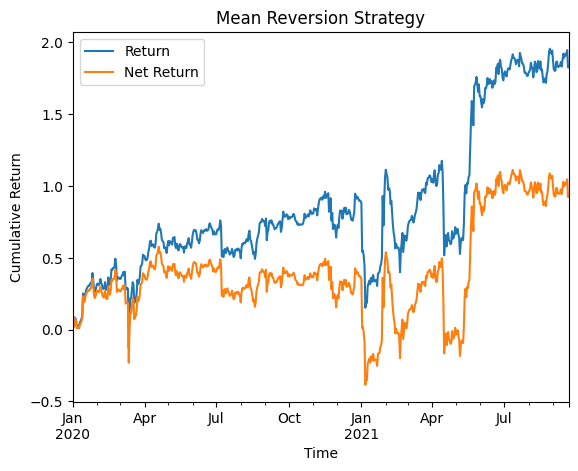

In [38]:
pos =  -R.rolling(1).mean().shift(1)
pos_mr = pos.div(pos.abs().sum(1),0)
ret_mr = pos_mr * R.reindex_like(pos_mr)
results_mr = print_eval_metrics(pos_mr.loc['2020-01-01':],ret_mr.loc['2020-01-01':])
plt.show()

# Trend Following Strategy

The idea behind the  Trend following startegy is that long term well performing
stocks will keep performing well, while poor performing ones will perform less better.

Total Return (%): 350.81
Net Total Return (%): 346.46
Sharpe: 1.93
Net Sharpe: 1.90
Turnover (%): 6.90
Bias: 556.83
Net Bias: 549.94
Vol (%): 105.46
Max Draw Down (%): -31.67


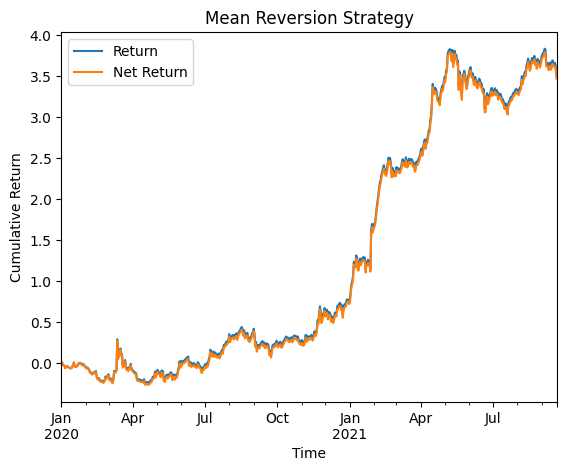

In [39]:
pos =  R.rolling(252,min_periods=10).mean().shift(1)

#pos = pos.sub( pos.mean(1),0)
pos_tf = pos.div(pos.abs().sum(1),0)


ret_tf = pos_tf * R.reindex_like(pos_tf)
tf_results = print_eval_metrics(pos_tf.loc['2020-01-01':],ret_tf.loc['2020-01-01':], title="Trend Following Strategy")
plt.show()

# LSTM


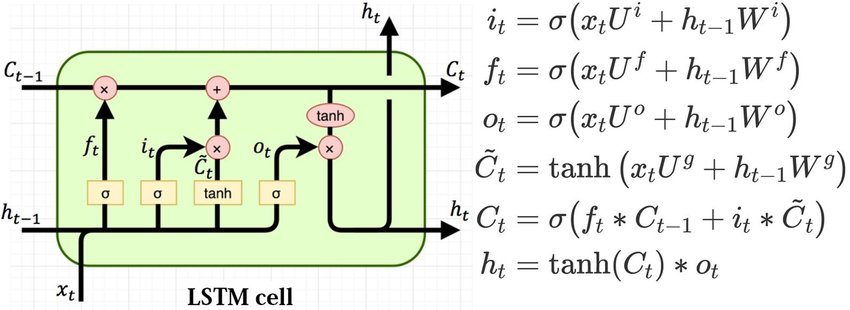

**Long Short-Term Memory (LSTM)** networks are a type of recurrent neural network. Unlike standard feedforward neural networks, LSTM has feedback connections. It can process not only single data points (such as images), but also entire sequences of data (such as speech or video).

A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell.



In [40]:
raw_cum_lags = [1,2,3,4,5,7,10,15,30,60,90,120,150,360]
norm_cum_lags= [1,2,3,4,5,7,10,15,30,60,90,120,150,360]

features_ = {
    'raw_ret':raw_cum_lags,
    'norm_ret':norm_cum_lags,
}

In [41]:
def raw_cum_feature(df, lag):
    raw_ret = (df / df.groupby(level='Asset_ID').shift(lag)) - 1
    return raw_ret

def norm_ret_feature(df, lag):
    R = (df / df.groupby(level='Asset_ID').shift(1)) - 1
    std_lag = 252
    std = R.groupby(level='Asset_ID').apply(lambda x: x.rolling(std_lag, min_periods=10).std())
    std.index = std.index.set_names(['Asset_ID_1', 'timestamp', 'Asset_ID'])
    new_index = std.index.droplevel('Asset_ID_1')
    std.index = new_index
    norm_ret = ( (df / df.groupby(level='Asset_ID').shift(lag)) - 1 ) / ( std * np.sqrt(std_lag))


    return norm_ret

def build_Y_score_return(unstacked_target,horizon):

    total_df = pd.DataFrame((unstacked_target*100).stack(), columns = ['y_'+str(horizon)])

    return total_df.sort_index()

In [42]:
def build_df(df, targets, features):
    total_df = None
    for horizon in tqdm(targets):
        if total_df is None:
            total_df =  build_Y_score_return(df['Close'].astype(float).unstack().pct_change(horizon).shift(-horizon),horizon)
        else:
            total_df['y_'+str(horizon)] =  build_Y_score_return(df['Close'].astype(float).unstack().pct_change(horizon).shift(-horizon),horizon)['y_'+str(horizon)]

    for raw_lag in tqdm(features['raw_ret']):
        total_df['raw_cum_return_%s'%raw_lag] = raw_cum_feature(df['Close'], raw_lag)

    for norm_lag in tqdm(features['norm_ret']):
        total_df['norm_return_%s'%norm_lag] = norm_ret_feature(df['Close'], norm_lag)

    return total_df

In [46]:
targets = [1,2,3,5,7,10,15,30]
total_df = build_df(df, targets, features_)
kept_total_df = total_df[total_df.notna().sum(1) / (len(total_df.columns) - len(targets)) > 0.6]

100%|██████████| 14/14 [00:00<00:00, 55.12it/s]


In [47]:
total_df

y_1        y_2        y_3         y_5         y_7  \
timestamp  Asset_ID                                                            
2018-01-01 0          3.136095  10.106509   8.201183  167.455621  112.983432   
           1          9.775940  12.425268  12.818079   27.429070   11.406725   
           2         10.076157   9.978592   1.582009    8.874358    3.501585   
           5          8.625295  23.461639  23.993192   28.678974   25.667714   
           6         13.877010  24.144945  24.760790   32.714843   50.034893   
...                        ...        ...        ...         ...         ...   
2021-09-20 9         -0.178816        NaN        NaN         NaN         NaN   
           10        -0.112692        NaN        NaN         NaN         NaN   
           11         0.007319        NaN        NaN         NaN         NaN   
           12        -0.009547        NaN        NaN         NaN         NaN   
           13         0.025349        NaN        NaN         NaN         NaN   

                           y_10       y_15       y_30  raw_cum_return_1  \
timestamp  Asset_ID                                                       
2018-01-01 0         150.915976  56.208284  33.882840               NaN   
           1          -1.221834 -16.413681 -24.106738               NaN   
           2           4.891623 -23.586185 -36.073672               NaN   
           5          47.577900  29.680545  56.873527               NaN   
           6          50.549729  37.092786  47.515178               NaN   
...                         ...        ...        ...               ...   
2021-09-20 9                NaN        NaN        NaN         -0.104750   
           10               NaN        NaN        NaN         -0.119676   
           11               NaN        NaN        NaN         -0.106333   
           12               NaN        NaN        NaN         -0.100015   
           13               NaN        NaN        NaN         -0.119259   

                     raw_cum_return_2  ...  norm_return_5  norm_return_7  \
timestamp  Asset_ID                    ...                                 
2018-01-01 0                      NaN  ...            NaN            NaN   
           1                      NaN  ...            NaN            NaN   
           2                      NaN  ...            NaN            NaN   
           5                      NaN  ...            NaN            NaN   
           6                      NaN  ...            NaN            NaN   
...                               ...  ...            ...            ...   
2021-09-20 9                -0.133201  ...      -0.163075      -0.119006   
           10               -0.142523  ...      -0.160466      -0.104235   
           11               -0.145209  ...      -0.128772      -0.110639   
           12               -0.124624  ...      -0.159819      -0.106116   
           13               -0.137665  ...      -0.204474      -0.107112   

                     norm_return_10  norm_return_15  norm_return_30  \
timestamp  Asset_ID                                                   
2018-01-01 0                    NaN             NaN             NaN   
           1                    NaN             NaN             NaN   
           2                    NaN             NaN             NaN   
           5                    NaN             NaN             NaN   
           6                    NaN             NaN             NaN   
...                             ...             ...             ...   
2021-09-20 9              -0.093872       -0.312566       -0.120768   
           10             -0.097712       -0.270679       -0.290527   
           11             -0.063570       -0.247165       -0.181750   
           12             -0.101612       -0.269144       -0.222863   
           13              0.005239       -0.110726        0.031890   

                     norm_return_60  norm_return_90  norm_return_120  \
timestamp  Asset_ID      

In [48]:
kept_total_df

y_1        y_2        y_3        y_5        y_7  \
timestamp  Asset_ID                                                          
2018-01-11 0          4.704656   4.233483  -3.529317 -37.744784 -33.310852   
           1          3.871446   7.270545   2.404502 -15.379762 -15.967068   
           2          6.510156   9.297573   4.007671 -27.149745 -29.787009   
           5         22.444996  41.944642  17.547906 -12.127395  -9.368346   
           6         10.413203  21.822981  18.948842  -8.938537 -11.223759   
...                        ...        ...        ...        ...        ...   
2021-09-20 9         -0.178816        NaN        NaN        NaN        NaN   
           10        -0.112692        NaN        NaN        NaN        NaN   
           11         0.007319        NaN        NaN        NaN        NaN   
           12        -0.009547        NaN        NaN        NaN        NaN   
           13         0.025349        NaN        NaN        NaN        NaN   

                          y_10       y_15       y_30  raw_cum_return_1  \
timestamp  Asset_ID                                                      
2018-01-11 0        -33.340565 -38.052296 -56.372863          0.211566   
           1        -13.108078 -16.447242 -35.559339         -0.109522   
           2        -27.318062 -34.627610 -49.093972         -0.147637   
           5         19.508517  26.823101 -20.777147          0.006429   
           6         -7.900426  -7.825379 -25.198278         -0.087065   
...                        ...        ...        ...               ...   
2021-09-20 9               NaN        NaN        NaN         -0.104750   
           10              NaN        NaN        NaN         -0.119676   
           11              NaN        NaN        NaN         -0.106333   
           12              NaN        NaN        NaN         -0.100015   
           13              NaN        NaN        NaN         -0.119259   

                     raw_cum_return_2  ...  norm_return_5  norm_return_7  \
timestamp  Asset_ID                    ...                                 
2018-01-11 0                 0.218599  ...      -0.015053       0.321058   
           1                -0.081441  ...      -0.195877      -0.108417   
           2                 0.025350  ...      -0.023825       0.021220   
           5                 0.222971  ...       0.110301       0.142851   
           6                -0.116110  ...       0.114143       0.175571   
...                               ...  ...            ...            ...   
2021-09-20 9                -0.133201  ...      -0.163075      -0.119006   
           10               -0.142523  ...      -0.160466      -0.104235   
           11               -0.145209  ...      -0.128772      -0.110639   
           12               -0.124624  ...      -0.159819      -0.106116   
           13               -0.137665  ...      -0.204474      -0.107112   

                     norm_return_10  norm_return_15  norm_return_30  \
timestamp  Asset_ID                                                   
2018-01-11 0               0.367351             NaN             NaN   
           1              -0.010644             NaN             NaN   
           2               0.031859             NaN             NaN   
           5               0.357318             NaN             NaN   
           6               0.429355             NaN             NaN   
...                             ...             ...             ...   
2021-09-20 9              -0.093872       -0.312566       -0.120768   
           10             -0.097712       -0.270679       -0.290527   
           11             -0.063570       -0.247165       -0.181750   
           12             -0.101612       -0.269144       -0.222863   
           13              0.005239       -0.110726        0.031890   

                     norm_return_60  norm_return_90  norm_return_120  \
timestamp  Asset_ID                                             

Target :  1
Data is ready


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 128)             │          80,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 343,681 (1.31 MB)

 Trainable params: 343,681 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 22s 333ms/step - loss: 34.5866 - val_loss: 18.8713
Epoch 2/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 485ms/step - loss: 34.1129 - val_loss: 18.7715
Epoch 3/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 35s 372ms/step - loss: 37.5010 - val_loss: 19.4326
Epoch 4/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 310ms/step - loss: 35.4250 - val_loss: 19.7115
Epoch 5/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 22s 327ms/step - loss: 34.1611 - val_loss: 18.8878
Epoch 6/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 347ms/step - loss: 36.7063 - val_loss: 18.8160
Epoch 7/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 326ms/step - loss: 35.6336 - val_loss: 18.5660
Epoch 8/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 18s 365ms/step - loss: 34.4719 - val_loss: 20.6496
Epoch 9/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 312ms/step - loss: 33.9101 - val_loss: 19.6502
Epoch 10/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 308ms/step - loss: 35.2561 - val_loss: 19.0099
Epoch 11/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 317ms/step - loss: 33.9870 - val_loss: 18.6327
Epoch 12

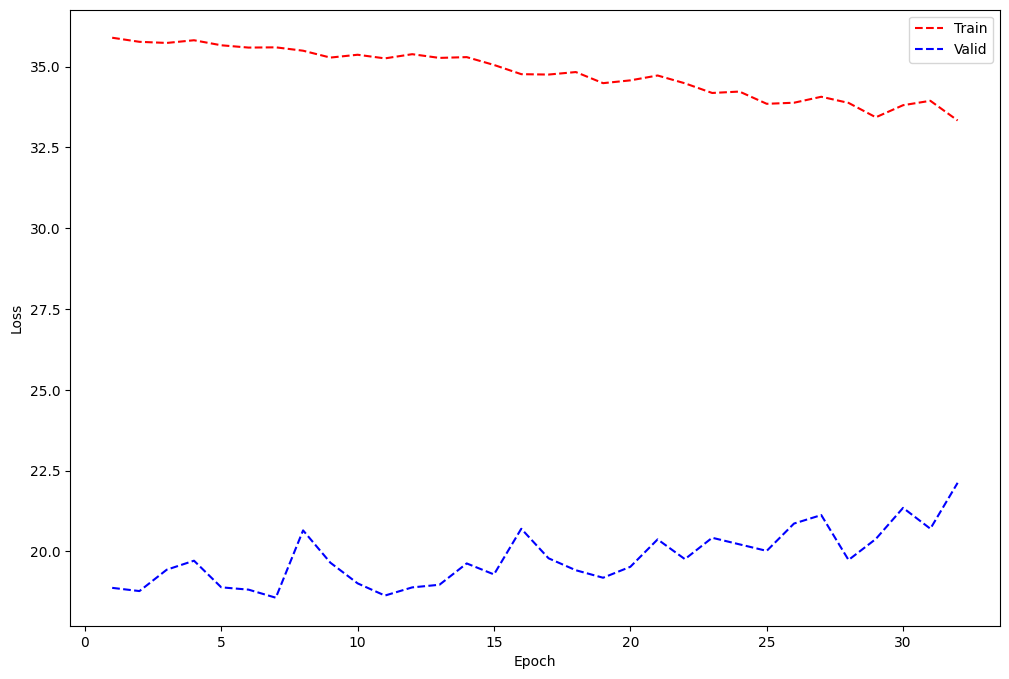

Target :  2
Data is ready


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 30, 128)             │          80,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 30, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 343,681 (1.31 MB)

 Trainable params: 343,681 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 393ms/step - loss: 63.2460 - val_loss: 35.7859
Epoch 2/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 26s 506ms/step - loss: 65.2995 - val_loss: 36.2392
Epoch 3/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 33s 330ms/step - loss: 67.9282 - val_loss: 39.3664
Epoch 4/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 345ms/step - loss: 67.3979 - val_loss: 37.3138
Epoch 5/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 358ms/step - loss: 64.4846 - val_loss: 35.0775
Epoch 6/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 316ms/step - loss: 64.1179 - val_loss: 40.5261
Epoch 7/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 333ms/step - loss: 59.9000 - val_loss: 36.6636
Epoch 8/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 19s 305ms/step - loss: 63.5845 - val_loss: 39.1395
Epoch 9/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 302ms/step - loss: 64.4380 - val_loss: 38.9265
Epoch 10/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 306ms/step - loss: 65.5951 - val_loss: 38.6525
Epoch 11/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 307ms/step - loss: 65.4273 - val_loss: 42.2344
Epoch 12

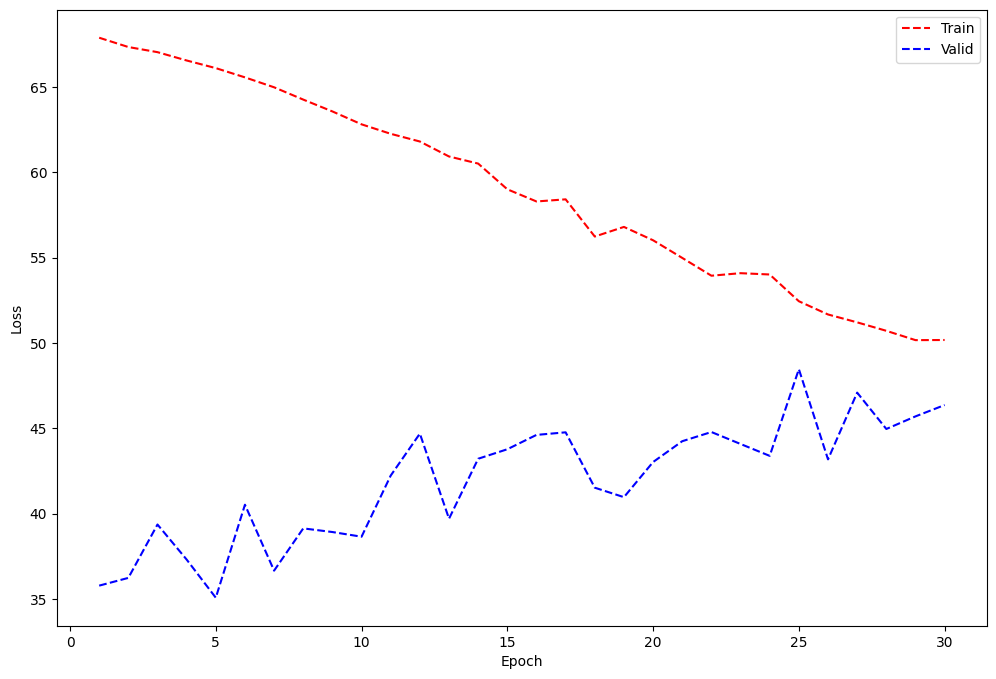

Target :  3
Data is ready


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 30, 128)             │          80,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 30, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 343,681 (1.31 MB)

 Trainable params: 343,681 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 326ms/step - loss: 101.8640 - val_loss: 51.2719
Epoch 2/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 313ms/step - loss: 107.8578 - val_loss: 53.8153
Epoch 3/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 314ms/step - loss: 102.2321 - val_loss: 57.2377
Epoch 4/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 319ms/step - loss: 102.1604 - val_loss: 55.5010
Epoch 5/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 313ms/step - loss: 106.4662 - val_loss: 54.7227
Epoch 6/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 313ms/step - loss: 92.4941 - val_loss: 62.4584
Epoch 7/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 312ms/step - loss: 98.1236 - val_loss: 60.3259
Epoch 8/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 309ms/step - loss: 95.4141 - val_loss: 60.7681
Epoch 9/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 307ms/step - loss: 97.1995 - val_loss: 64.7737
Epoch 10/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 305ms/step - loss: 96.9363 - val_loss: 58.9070
Epoch 11/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 307ms/step - loss: 90.3754 - val_loss: 66.4108
Epo

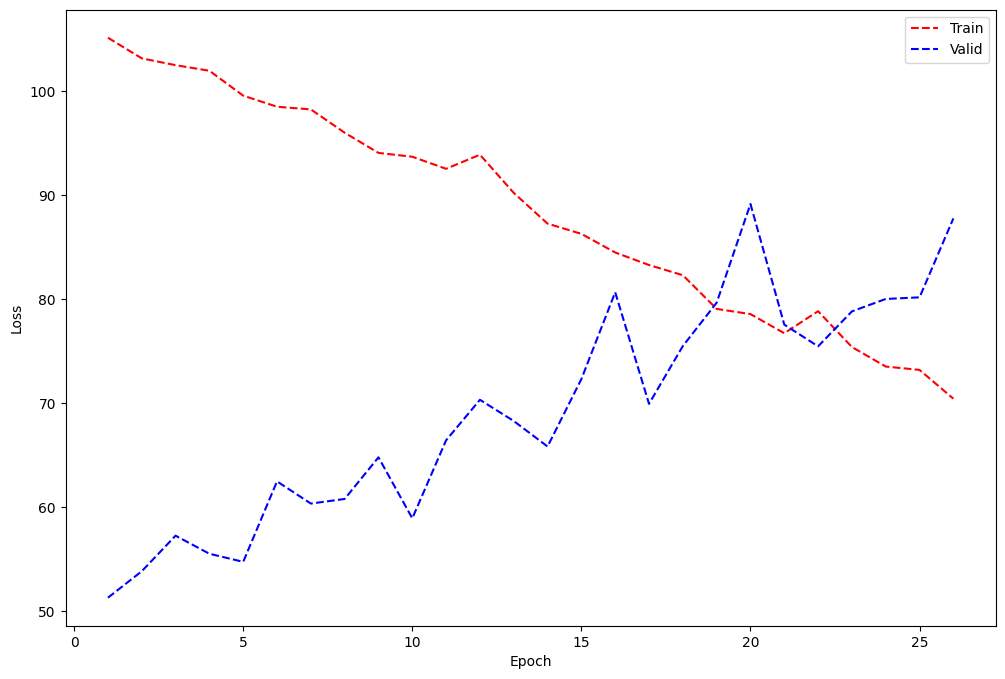

Target :  5
Data is ready


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                        │ (None, 30, 128)             │          80,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 30, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 343,681 (1.31 MB)

 Trainable params: 343,681 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 340ms/step - loss: 179.4378 - val_loss: 83.2424
Epoch 2/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 19s 308ms/step - loss: 184.0036 - val_loss: 87.7860
Epoch 3/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 313ms/step - loss: 177.9492 - val_loss: 95.3033
Epoch 4/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 316ms/step - loss: 165.1336 - val_loss: 95.0127
Epoch 5/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 309ms/step - loss: 168.2142 - val_loss: 93.4541
Epoch 6/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 308ms/step - loss: 162.7995 - val_loss: 108.6658
Epoch 7/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 305ms/step - loss: 151.1183 - val_loss: 112.7242
Epoch 8/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 301ms/step - loss: 159.7434 - val_loss: 118.4353
Epoch 9/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 308ms/step - loss: 142.9367 - val_loss: 113.0384
Epoch 10/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 307ms/step - loss: 145.5878 - val_loss: 124.1167
Epoch 11/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 314ms/step - loss: 139.0894 - val_loss: 

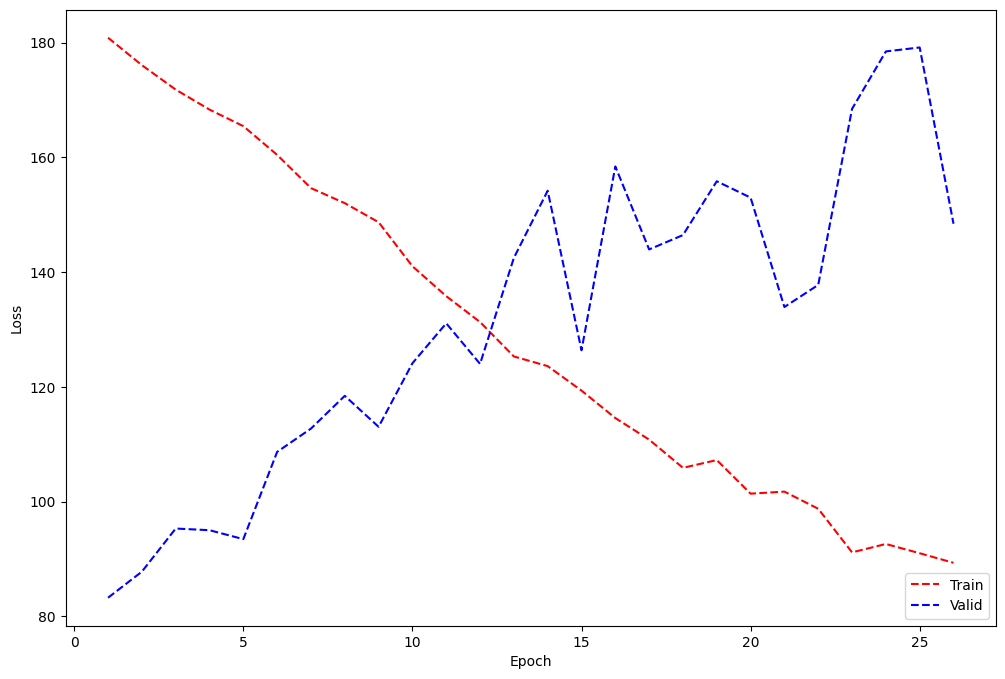

Target :  7
Data is ready


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 30, 128)             │          80,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 30, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 343,681 (1.31 MB)

 Trainable params: 343,681 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 315ms/step - loss: 260.0236 - val_loss: 113.8901
Epoch 2/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - loss: 241.4967 - val_loss: 141.9226
Epoch 3/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 293ms/step - loss: 232.2796 - val_loss: 139.0828
Epoch 4/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 301ms/step - loss: 218.2139 - val_loss: 148.9461
Epoch 5/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 311ms/step - loss: 228.3736 - val_loss: 147.1866
Epoch 6/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 297ms/step - loss: 223.3671 - val_loss: 144.4837
Epoch 7/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 300ms/step - loss: 220.1375 - val_loss: 150.5057
Epoch 8/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 304ms/step - loss: 189.5703 - val_loss: 215.2031
Epoch 9/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 301ms/step - loss: 189.8309 - val_loss: 152.7720
Epoch 10/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 297ms/step - loss: 201.2938 - val_loss: 184.9255
Epoch 11/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 299ms/step - loss: 172.2400 - val_l

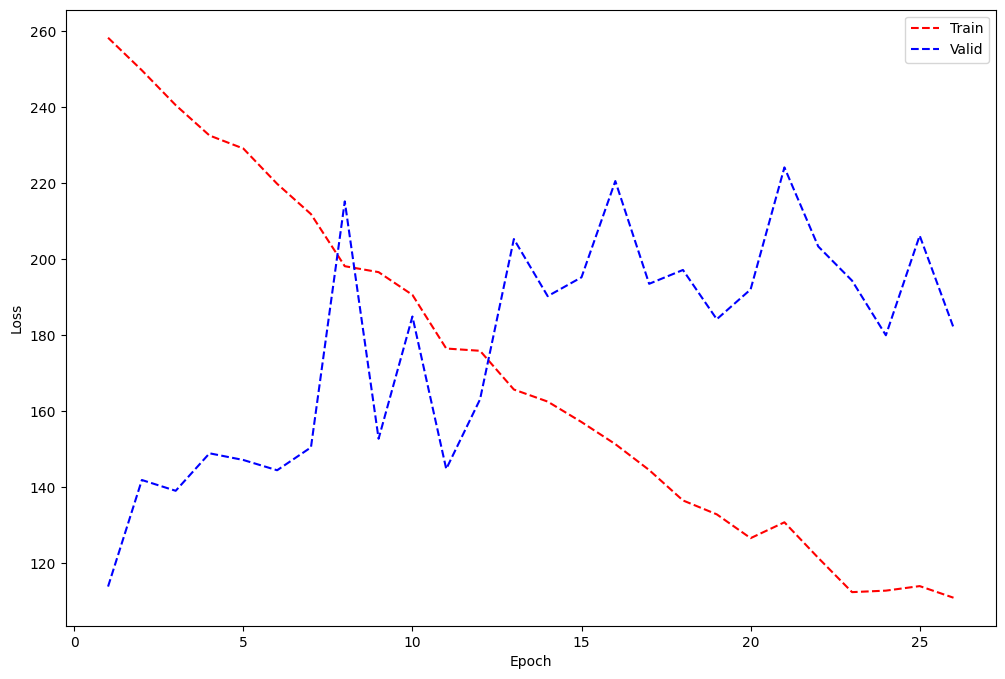

Target :  10
Data is ready


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                       │ (None, 30, 128)             │          80,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 30, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 343,681 (1.31 MB)

 Trainable params: 343,681 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 346ms/step - loss: 378.1147 - val_loss: 202.1782
Epoch 2/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 299ms/step - loss: 356.3962 - val_loss: 204.8723
Epoch 3/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 298ms/step - loss: 342.5570 - val_loss: 259.6205
Epoch 4/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 298ms/step - loss: 317.8176 - val_loss: 247.9814
Epoch 5/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 302ms/step - loss: 301.1358 - val_loss: 257.9122
Epoch 6/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 310ms/step - loss: 283.1802 - val_loss: 285.1978
Epoch 7/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 301ms/step - loss: 263.7375 - val_loss: 329.4969
Epoch 8/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 299ms/step - loss: 257.5367 - val_loss: 268.1485
Epoch 9/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 300ms/step - loss: 244.2004 - val_loss: 355.9671
Epoch 10/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 300ms/step - loss: 219.2159 - val_loss: 363.9135
Epoch 11/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 300ms/step - loss: 219.1189 - val_l

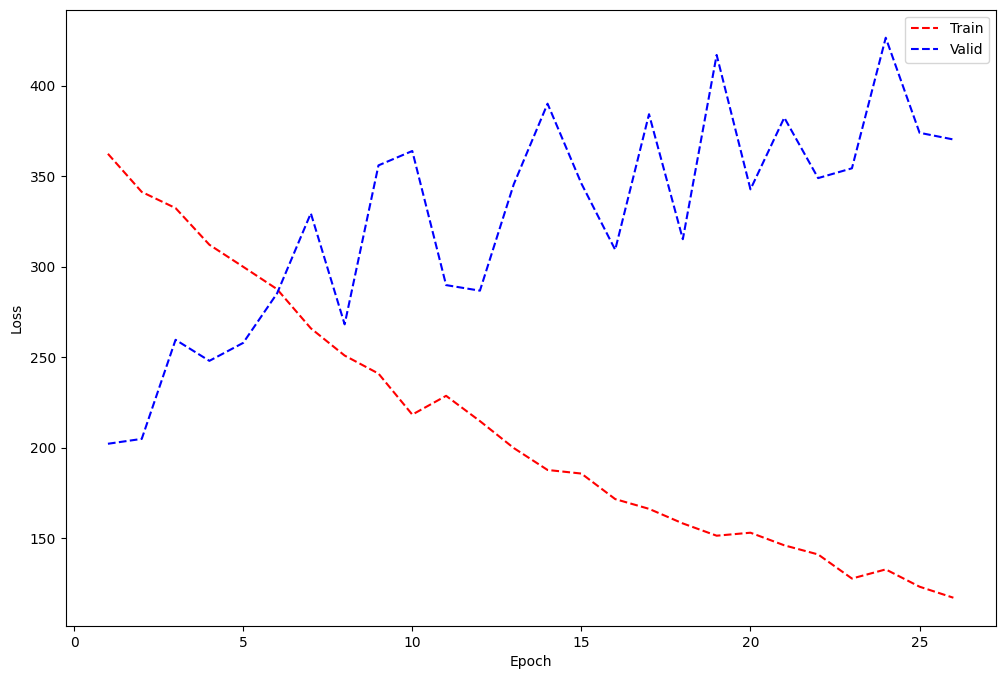

Target :  15
Data is ready


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                       │ (None, 30, 128)             │          80,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 30, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_20 (LSTM)                       │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 343,681 (1.31 MB)

 Trainable params: 343,681 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 329ms/step - loss: 554.4275 - val_loss: 334.3185
Epoch 2/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 19s 301ms/step - loss: 522.7073 - val_loss: 346.0385
Epoch 3/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 310ms/step - loss: 515.2965 - val_loss: 405.6334
Epoch 4/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 302ms/step - loss: 497.7779 - val_loss: 350.6928
Epoch 5/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 301ms/step - loss: 502.3424 - val_loss: 432.9780
Epoch 6/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 298ms/step - loss: 436.0689 - val_loss: 446.8591
Epoch 7/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 301ms/step - loss: 418.5757 - val_loss: 429.7145
Epoch 8/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 295ms/step - loss: 416.5130 - val_loss: 632.5357
Epoch 9/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 301ms/step - loss: 378.7337 - val_loss: 538.4447
Epoch 10/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 302ms/step - loss: 343.0413 - val_loss: 586.1714
Epoch 11/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 301ms/step - loss: 348.1245 - val_l

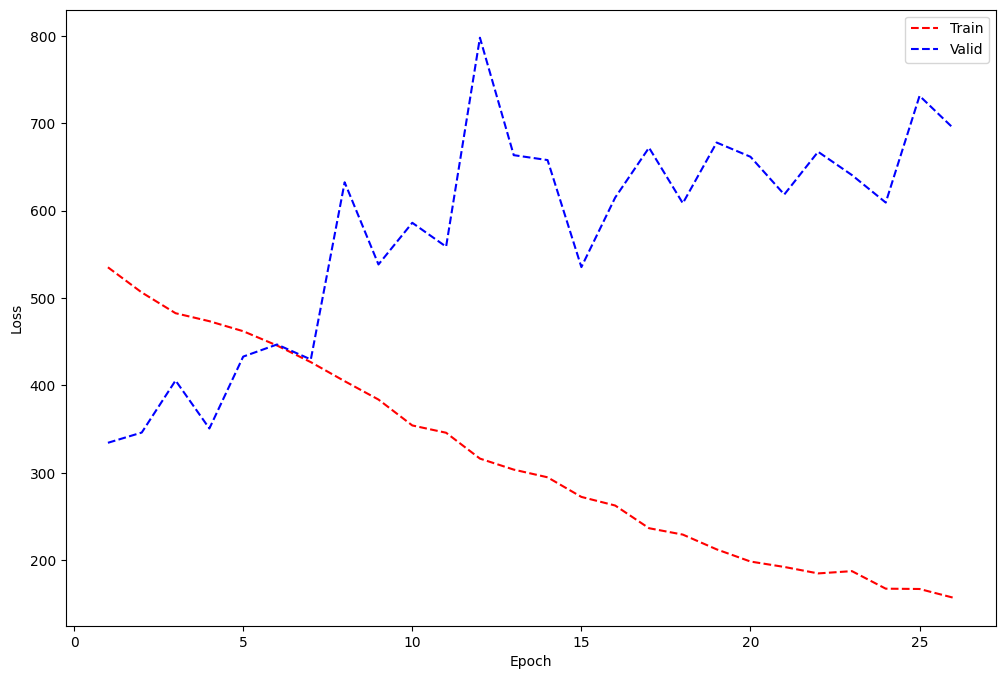

Target :  30
Data is ready


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                       │ (None, 30, 128)             │          80,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_22 (LSTM)                       │ (None, 30, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_23 (LSTM)                       │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 343,681 (1.31 MB)

 Trainable params: 343,681 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 310ms/step - loss: 1089.4012 - val_loss: 908.3575
Epoch 2/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 303ms/step - loss: 957.6657 - val_loss: 960.9061
Epoch 3/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 299ms/step - loss: 940.7493 - val_loss: 1148.4415
Epoch 4/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 312ms/step - loss: 862.3561 - val_loss: 1127.5203
Epoch 5/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 306ms/step - loss: 729.5975 - val_loss: 1131.7753
Epoch 6/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 307ms/step - loss: 810.9805 - val_loss: 1199.5980
Epoch 7/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 307ms/step - loss: 704.8547 - val_loss: 1251.2678
Epoch 8/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 307ms/step - loss: 717.7054 - val_loss: 1186.3314
Epoch 9/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 308ms/step - loss: 623.4662 - val_loss: 1453.4343
Epoch 10/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 315ms/step - loss: 627.2186 - val_loss: 1277.9176
Epoch 11/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 306ms/step - loss: 603.554

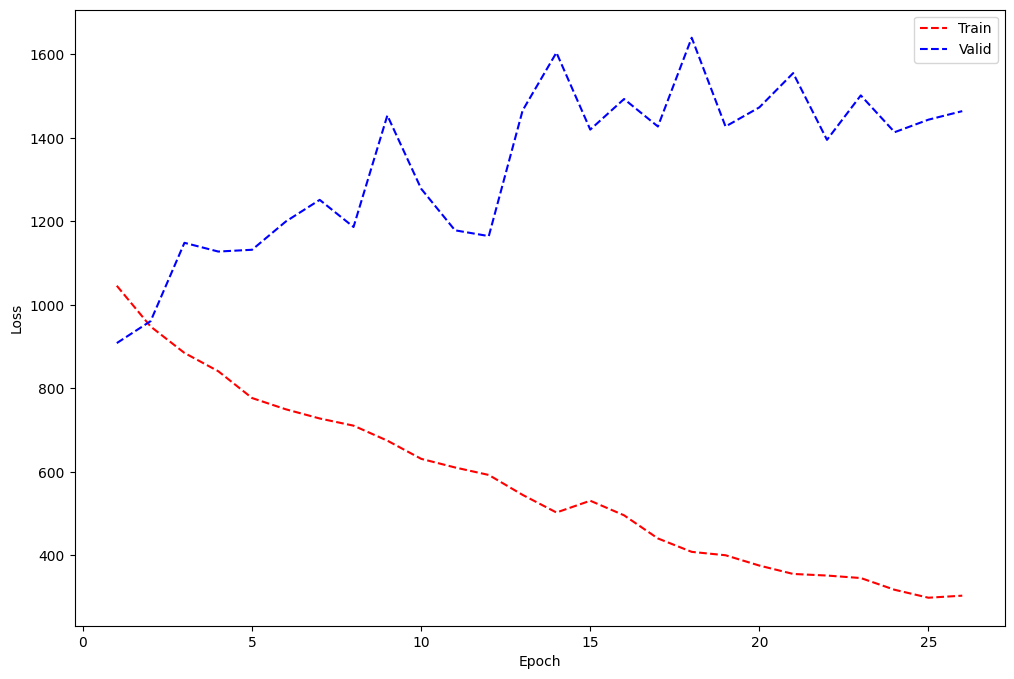

In [49]:
preds_lstm_dfs = {}
for horizon in targets:
    print('Target : ', horizon)
    train_df = kept_total_df.loc[:'2019-06-01'].reset_index().set_index(['Asset_ID','timestamp']).sort_index().fillna(0)
    valid_df = kept_total_df.loc['2019-06-01':'2020-01-01'].reset_index().set_index(['Asset_ID','timestamp']).sort_index().fillna(0)
    test_df = kept_total_df.loc['2020-01-01':].iloc[:-(horizon*13)].reset_index().set_index(['Asset_ID','timestamp']).sort_index().fillna(0)
    features = kept_total_df.columns[len(targets):]

    data = [i for i in np.array(train_df.iloc[:,len(targets):])]
    targets_ = train_df['y_'+str(horizon)].values
    hist = []
    target = []
    length = 30
    for i in range(len(data)-length):
        x = data[i:i+length]
        y = targets_[i+length-1]
        hist.append(x)
        target.append(y)
    hist = np.array(hist)
    target = np.array(target)
    target = target.reshape(-1,1)

    X_train, y_train = hist,target


    data = [i for i in np.array(valid_df.iloc[:,len(targets):])]
    targets_ = valid_df['y_'+str(horizon)].values
    hist = []
    target = []
    length = 30
    for i in range(len(data)-length):
        x = data[i:i+length]
        y = targets_[i+length-1]
        hist.append(x)
        target.append(y)
    hist = np.array(hist)
    target = np.array(target)
    target = target.reshape(-1,1)

    X_valid, y_valid = hist,target

    data = [i for i in np.array(test_df.iloc[:,len(targets):])]
    targets_ = test_df['y_'+str(horizon)].values
    hist = []
    target = []
    length = 30
    for i in range(len(data)-length):
        x = data[i:i+length]
        y = targets_[i+length-1]
        hist.append(x)
        target.append(y)
    hist = np.array(hist)
    target = np.array(target)
    target = target.reshape(-1,1)

    X_test = hist


    print('Data is ready')

    model = tf.keras.Sequential()
    model.add(layers.LSTM(units=128, return_sequences=True,
                      input_shape=(30,28), dropout=0.2))
    model.add(layers.LSTM(units=128, return_sequences=True,
                      dropout=0.2))
    model.add(layers.LSTM(units=128, dropout=0.2))
    model.add(layers.Dense(units=1))
    model.summary()

    model.compile(optimizer='adam', loss='mean_squared_error')

    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, mode='min', verbose=1)
    history = model.fit(X_train, y_train, epochs=200, batch_size=128, validation_data=(X_valid, y_valid),callbacks=[callback])

    preds = model.predict(X_test)
    preds_df = pd.DataFrame(index = test_df.index).iloc[length:]
    preds_df['Output'] = preds
    preds_lstm_dfs[horizon] = preds_df

    loss = history.history['loss']
    valid_loss = history.history['val_loss']
    epoch_count = range(1, len(loss) + 1)
    plt.figure(figsize=(12,8))
    plt.plot(epoch_count, loss, 'r--',label='Train')
    plt.plot(epoch_count, valid_loss, 'b--',label='Valid')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()


In [51]:
for horizon in tqdm(targets):
    df__ = preds_lstm_dfs[horizon]['Output'].unstack().T
    df__.columns = df__.columns.astype(str)
    df__.to_parquet('preds_lstm_hor_%s.parquet' %horizon)

100%|██████████| 8/8 [00:00<00:00, 70.50it/s]


In [52]:
targets = [1,2,3,5,7,10,15,30]
preds_lstm_dfs = {}
for horizon in tqdm(targets):
    preds_lstm_dfs[horizon] = pd.read_parquet('preds_lstm_hor_%s.parquet' %horizon)
    preds_lstm_dfs[horizon].columns = preds_lstm_dfs[horizon].columns.astype(int)
    preds_lstm_dfs[horizon].index = pd.to_datetime(preds_lstm_dfs[horizon].index)

100%|██████████| 8/8 [00:00<00:00, 16.41it/s]


1
Total Return (%): 2.72
Net Total Return (%): -3.61
Sharpe: 0.02
Net Sharpe: -0.03
Turnover (%): 10.07
Bias: 4.33
Net Bias: -5.75
Vol (%): 74.29
Max Draw Down (%): -38.56


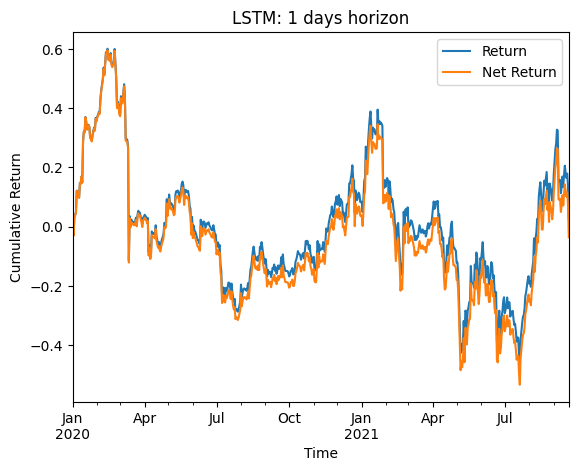

2
Total Return (%): 246.76
Net Total Return (%): 239.19
Sharpe: 1.55
Net Sharpe: 1.50
Turnover (%): 12.06
Bias: 392.93
Net Bias: 380.88
Vol (%): 92.52
Max Draw Down (%): -30.89


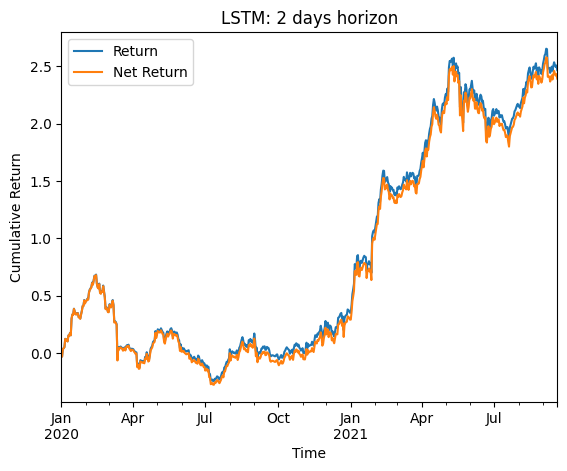

3
Total Return (%): 308.23
Net Total Return (%): 305.74
Sharpe: 1.84
Net Sharpe: 1.82
Turnover (%): 3.97
Bias: 491.59
Net Bias: 487.62
Vol (%): 97.70
Max Draw Down (%): -31.63


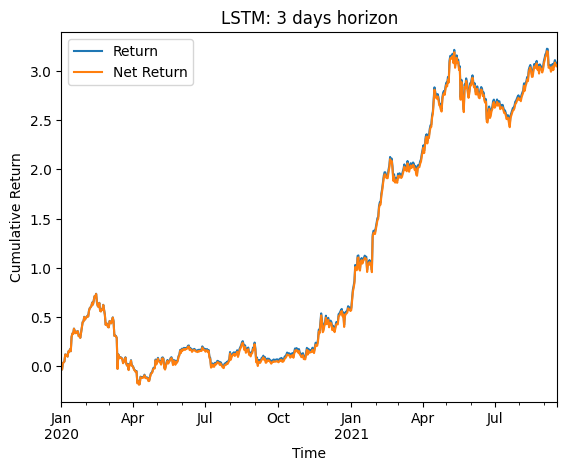

5
Total Return (%): 285.52
Net Total Return (%): 282.99
Sharpe: 1.71
Net Sharpe: 1.69
Turnover (%): 4.05
Bias: 456.84
Net Bias: 452.79
Vol (%): 97.55
Max Draw Down (%): -35.32


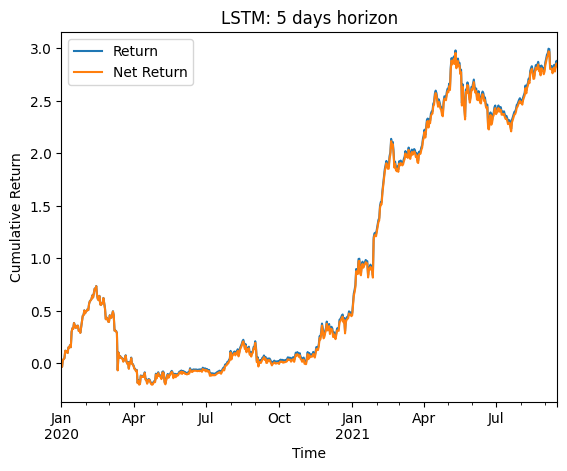

7
Total Return (%): 280.68
Net Total Return (%): 278.70
Sharpe: 1.63
Net Sharpe: 1.62
Turnover (%): 3.19
Bias: 450.53
Net Bias: 447.35
Vol (%): 100.82
Max Draw Down (%): -42.15


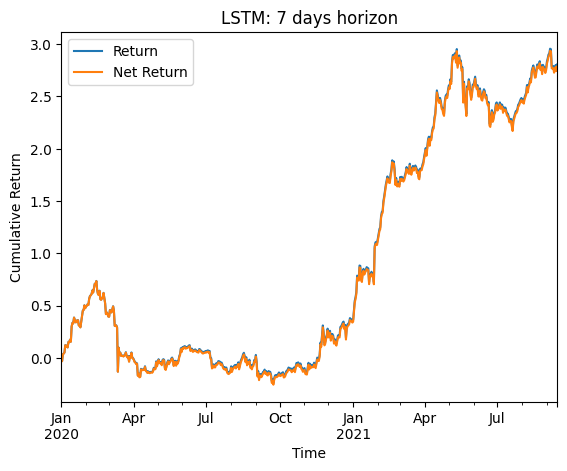

10
Total Return (%): 237.87
Net Total Return (%): 235.47
Sharpe: 1.41
Net Sharpe: 1.40
Turnover (%): 3.87
Bias: 383.67
Net Bias: 379.80
Vol (%): 99.00
Max Draw Down (%): -40.38


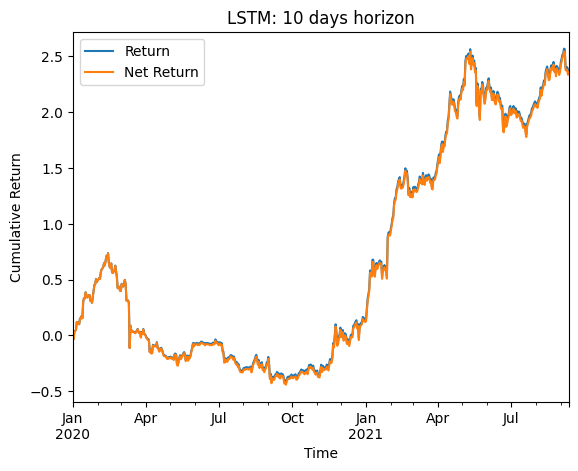

15
Total Return (%): 228.82
Net Total Return (%): 226.66
Sharpe: 1.36
Net Sharpe: 1.35
Turnover (%): 3.51
Bias: 371.46
Net Bias: 367.95
Vol (%): 99.53
Max Draw Down (%): -40.41


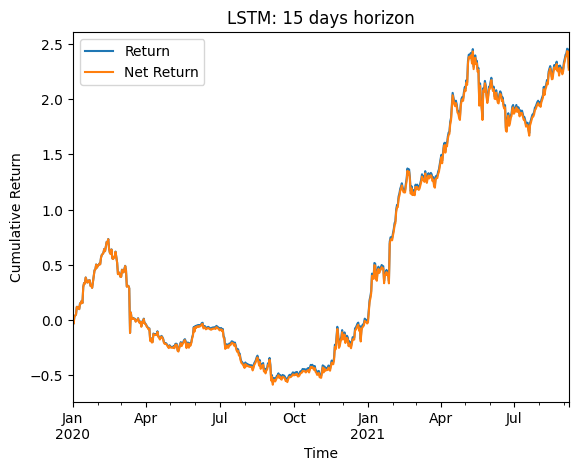

30
Total Return (%): 208.16
Net Total Return (%): 205.81
Sharpe: 1.49
Net Sharpe: 1.47
Turnover (%): 3.90
Bias: 345.78
Net Bias: 341.89
Vol (%): 84.91
Max Draw Down (%): -30.00


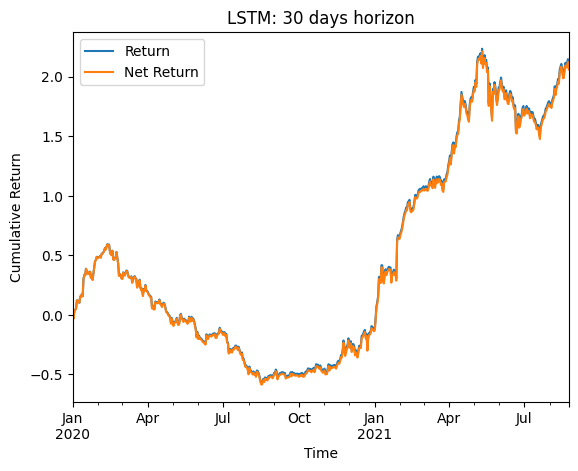

In [53]:
 for horizon in targets:
    print(horizon)
    pos =  -preds_lstm_dfs[horizon].shift(1) #.ewm(span=int(1+(horizon/3))).mean()#.dropna(how='all')#.ewm(2).mean()#

    #pos = pos.sub( pos.mean(1),0)
    pos = pos.div(pos.abs().sum(1),0)
    ret = pos * R.reindex_like(pos)
    #     pos_xgb = pos
    #     ret_xgb = ret
    #     xgb_results =
    _ = print_eval_metrics(pos,ret, title =f"LSTM: {horizon} days horizon")
    plt.show()

Total Return (%): 246.76
Net Total Return (%): 239.19
Sharpe: 1.55
Net Sharpe: 1.50
Turnover (%): 12.06
Bias: 392.93
Net Bias: 380.88
Vol (%): 92.52
Max Draw Down (%): -30.89


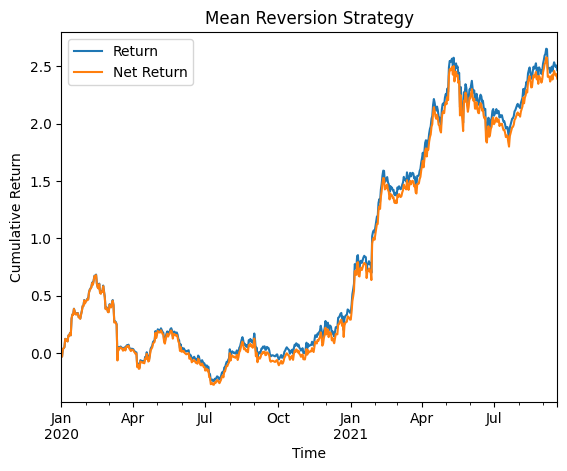

In [54]:
pos =  -preds_lstm_dfs[2].shift(1) #.ewm(span=int(1+(horizon/3))).mean()#.dropna(how='all')#.ewm(2).mean()#

#pos = pos.sub( pos.mean(1),0)
pos = pos.div(pos.abs().sum(1),0)
ret = pos * R.reindex_like(pos)
pos_lstm = pos
ret_lstm = ret
lstm_results = print_eval_metrics(pos,ret)
plt.show()

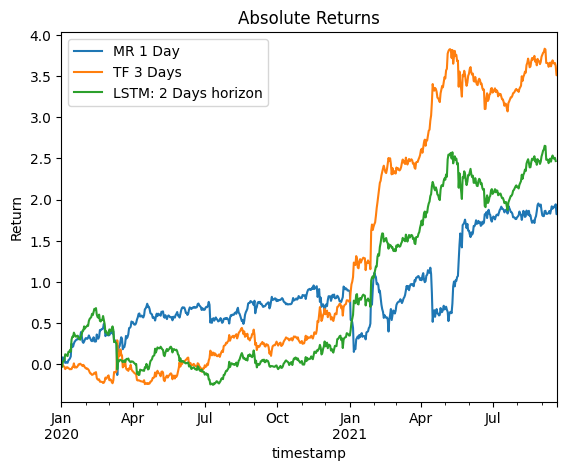

In [55]:
ret_mr.loc['2020-01-01':].sum(1).cumsum().plot(label='MR 1 Day')
ret_tf.loc['2020-01-01':].sum(1).cumsum().plot(label='TF 3 Days')
ret_lstm.sum(1).cumsum().plot(label='LSTM: 2 Days horizon')
plt.title('Absolute Returns')
plt.ylabel('Return')
plt.legend()
plt.show()

In [56]:
fees = 1e-3

# Markowitz

we consider that each stock has an expected return
and an expected risk when bought (std of daily return, also known as Volatility). Markowitz Optimization is a way of computing weights to build a portfolio of stocks minimizing the overall expected risk while maximizing the overall expected return.


When building such a portfolio, we need very good expected return and risk
estimators.

In [57]:

rets_ref = R.loc[:'2020-01-01 00:00:00']
perfs = rets_ref.fillna(0)
w, v = np.linalg.eig(perfs.cov())
u = np.array(perfs.mean())
weights = np.diag(u * v * np.linalg.inv(np.diag(w)) * np.linalg.inv(v))  # Expliquer Formule
weights = weights/np.sum(np.abs(weights))

In [58]:
weights = weights - np.mean(weights)
weights = weights/np.sum(np.abs(weights))

In [59]:
pos_mkw = pd.DataFrame().reindex_like(R)
pos_mkw = pos_mkw.fillna(1).mul(weights,axis=1)
ret_mkw = pos_mkw * R.reindex_like(pos_mkw)


Total Return (%): 42.94
Net Total Return (%): 42.94
Sharpe: 0.92
Net Sharpe: 0.92
Turnover (%): 0.00
Bias: 68.15
Net Bias: 68.15
Vol (%): 27.13
Max Draw Down (%): -7.38


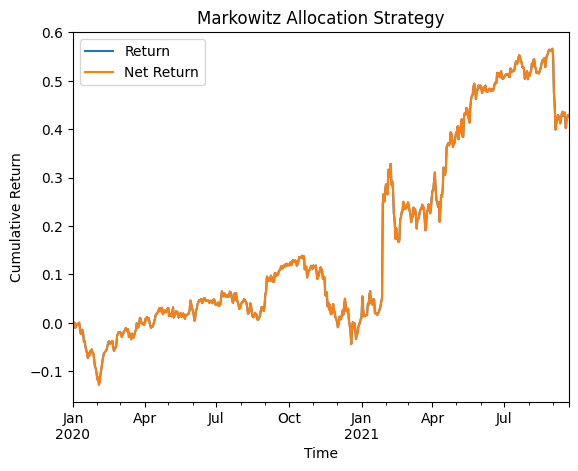

In [61]:
mkw_results = print_eval_metrics(pos_mkw.loc['2020-01-01':],ret_mkw.loc['2020-01-01':], title="Markowitz Allocation Strategy")
plt.show()

# Buy and hold

In [62]:
pos_buy_hold = pd.DataFrame().reindex_like(R)
pos_buy_hold = pos_buy_hold.fillna(1)
pos_buy_hold = pos_buy_hold.div(pos_buy_hold.abs().sum(1),0)

ret_buy_hold = pos_buy_hold * R.reindex_like(pos_buy_hold)


Total Return (%): 384.04
Net Total Return (%): 384.04
Sharpe: 2.14
Net Sharpe: 2.14
Turnover (%): 0.00
Bias: 609.59
Net Bias: 609.59
Vol (%): 104.18
Max Draw Down (%): -42.05


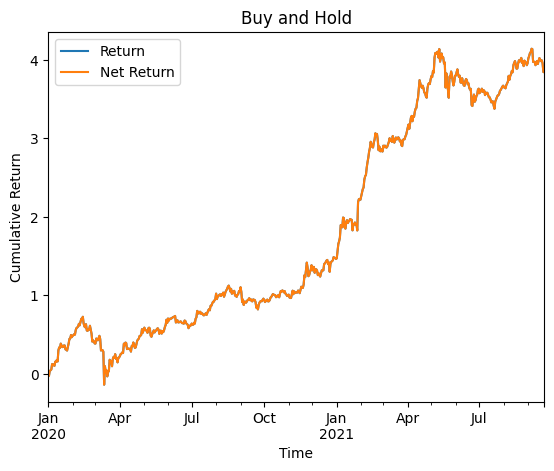

In [63]:
buy_hold_results = print_eval_metrics(pos_buy_hold.loc['2020-01-01':],ret_buy_hold.loc['2020-01-01':], title= 'Buy and Hold')
plt.show()

# Actor-Critic Algorithms

Actor-critic methods consist of two models, which may optionally share parameters:


- Critic updates the value function parameters w and depending on the
algorithm it could be action-value **$Q_w(s, a)$** or state-value **$V_w(s)$**
- Actor updates the policy parameters $\theta$ for **$\pi_{\theta}(a|s)$**, in the direction suggested by the critic.

## Pseudo-Code of ACA

1.  Initialize $\mathbf{s}$, $\theta$, $\mathbf{w}$ at random; sample $\mathbf{a} \sim \pi_{\theta}(\mathbf{a}|\mathbf{s})$.
2.  For $t = 1, \dots, T$:
      -  Sample reward $r_t \sim R(\mathbf{s}, \mathbf{a})$ and next state $\mathbf{s}' \sim P(\mathbf{s}'|\mathbf{s}, \mathbf{a})$.
      -  Then sample the next action $\mathbf{a}' \sim \pi_{\theta}(\mathbf{a}'|\mathbf{s}')$.
      -  Update the policy parameters:
       $$
        \theta \leftarrow \theta + \alpha_{\theta} Q_{\mathbf{w}}(\mathbf{s}, \mathbf{a}) \nabla_{\theta} \ln \pi_{\theta}(\mathbf{a}|\mathbf{s})
       $$
      -  Compute the correction (TD error) for action-value at time $t$:
       $$
        \delta_t = r_t + \gamma Q_{\mathbf{w}}(\mathbf{s}', \mathbf{a}') - Q_{\mathbf{w}}(\mathbf{s}, \mathbf{a})
       $$
      -  Use it to update the parameters of the action-value function:
       $$
        \mathbf{w} \leftarrow \mathbf{w} + \alpha_{\mathbf{w}} \delta_t \nabla_{\mathbf{w}} Q_{\mathbf{w}}(\mathbf{s}, \mathbf{a})
       $$
      -  Update $\mathbf{a} \leftarrow \mathbf{a}'$ and $\mathbf{s} \leftarrow \mathbf{s}'$.

Thee Two learning rates, $\alpha_\theta$ and $\alpha_w$ , are predefined for policy and value function parameter updates respectively.

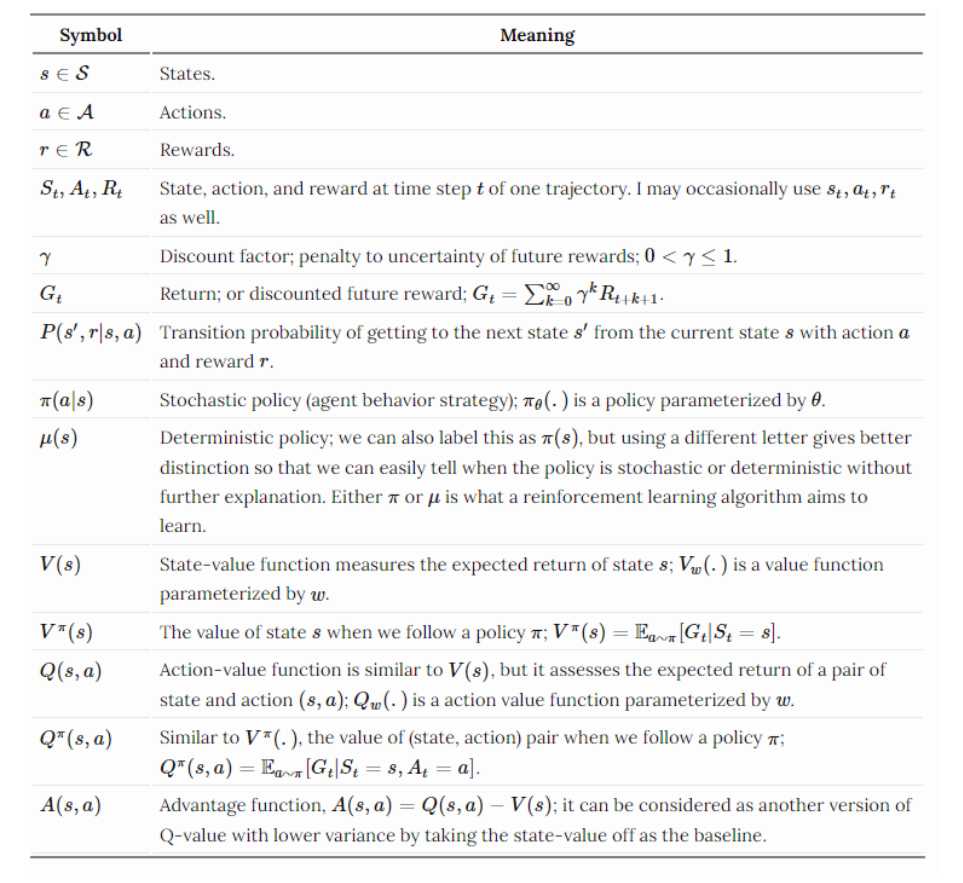

## A2C

**Asynchronous Advantage Actor-Critic** (Mnih et al., 2016), short for **A3C**, is a classic policy gradient method with a special focus on parallel training.  

**A2C** is a synchronous, deterministic version of **A3C**. In **A3C** each agent talks to the global parameters independently, so it is possible sometimes the thread-specific agents would be playing with policies of different versions and therefore the aggregated update would not be optimal. To resolve the inconsistency, a coordinator in **A2C** waits for all the parallel actors to finish their work before updating the global parameters and then in the next iteration parallel actors starts from the same policy.

The synchronized gradient update keeps the training more cohesive and potentially to make convergence faster.

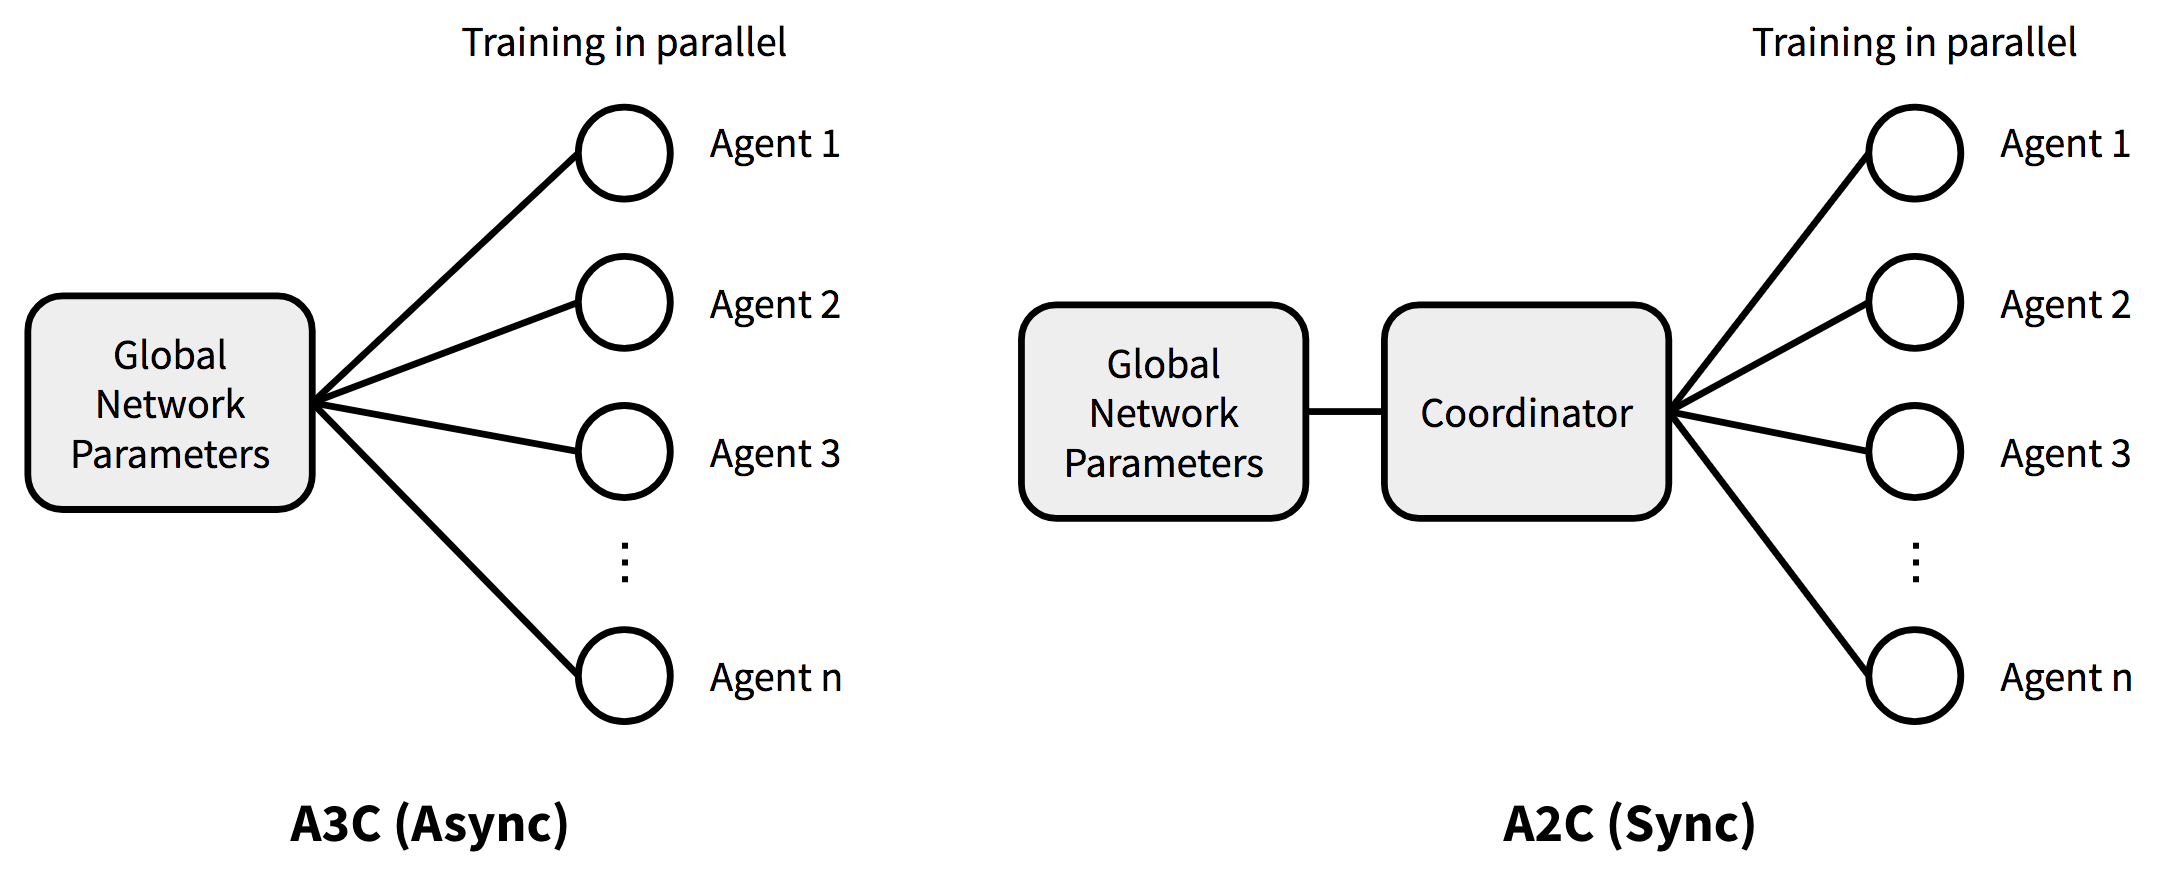

Total Return (%): 35.69
Net Total Return (%): -3.79
Sharpe: 0.81
Net Sharpe: -0.09
Turnover (%): 62.67
Bias: 56.65
Net Bias: -6.02
Vol (%): 25.65
Max Draw Down (%): -8.31


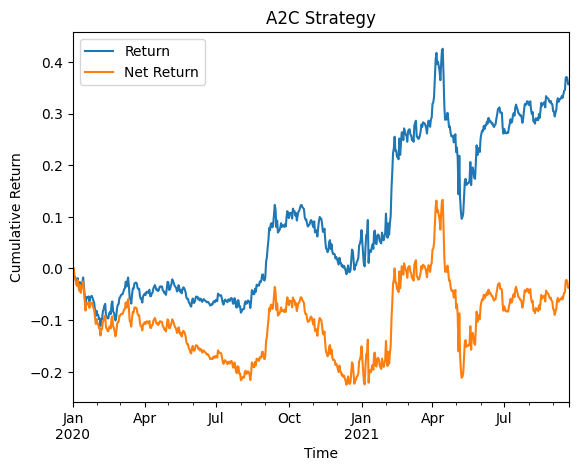

In [82]:
pos_a2c = pd.read_parquet('pos_a2c.parquet')
pos_a2c.columns = pos_a2c.columns.astype(int)
pos_a2c = -pos_a2c.sub( pos_a2c.mean(1),0)
pos_a2c = pos_a2c.div(pos_a2c.abs().sum(1),0)

ret_a2c = pos_a2c * R.reindex_like(pos_a2c)

a2c_results = print_eval_metrics(pos_a2c.loc['2020-01-01':],ret_a2c.loc['2020-01-01':], title="A2C Strategy")
plt.show()

## Proximal Policy Optimization (PPO)

To improve training stability, we should avoid parameter updates that change
the policy too much at one step. **Trust region policy optimization (TRPO)**
 (Schulman, et al., 2015) carries out this idea by enforcing a KL divergence constraint on the size of policy update at each iteration.  

Given that **TRPO** is relatively complicated, and we still could want to
implement a similar constraint, **proximal policy optimization (PPO)** simplifies it by using a clipped surrogate objective while retaining similar performance.

Total Return (%): 52.27
Net Total Return (%): -26.72
Sharpe: 1.11
Net Sharpe: -0.57
Turnover (%): 125.38
Bias: 82.97
Net Bias: -42.42
Vol (%): 27.25
Max Draw Down (%): -6.88


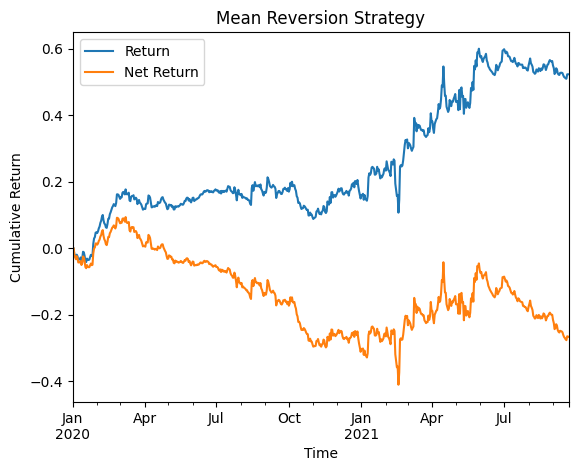

In [65]:

pos_ppo = pd.read_parquet('pos_ppo.parquet')

pos_ppo.columns = pos_ppo.columns.astype(int)

pos_ppo = pos_ppo.sub( pos_ppo.mean(1),0)
pos_ppo = pos_ppo.div(pos_ppo.abs().sum(1),0)

ret_ppo = pos_ppo * R.reindex_like(pos_ppo)

ppo_results = print_eval_metrics(pos_ppo.loc['2020-01-01':],ret_ppo.loc['2020-01-01':])
plt.show()

**Comparison**

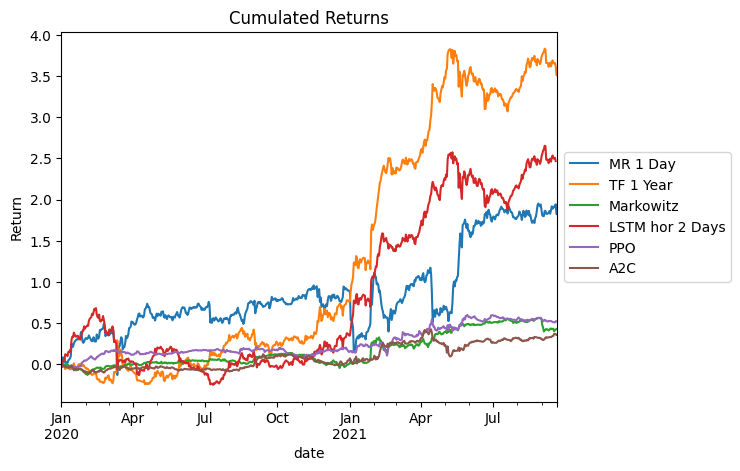

In [77]:
ret_mr.loc['2020-01-01':].sum(1).cumsum().plot(label='MR 1 Day')
ret_tf.loc['2020-01-01':].sum(1).cumsum().plot(label='TF 1 Year')
ret_mkw.loc['2020-01-01':].sum(1).cumsum().plot(label='Markowitz')
#=ret_buy_hold.loc['2020-01-01':].sum(1).cumsum().plot(label='Buy and Hold')
ret_lstm.sum(1).cumsum().plot(label='LSTM hor 2 Days')
ret_ppo.loc['2020-01-01':].sum(1).cumsum().plot(label='PPO')
ret_a2c.loc['2020-01-01':].sum(1).cumsum().plot(label='A2C')
plt.title('Cumulated Returns')
plt.ylabel('Return')
plt.legend(bbox_to_anchor=(1.,0.5), loc="center left")
plt.show()

In [78]:
results_df = pd.DataFrame(columns = ['Total_Ret (%)','Net_Total_Ret (%)','Sharpe', 'Net_Sharpe','Turnover (%)','Bias (Bp)','Net_Bias (Bp)','Vol (%)','max_draw_down (%)'],
                          index = ['Mean Reversing','Trend Following','LSTM','PPO','A2C','Markowitz'])

In [79]:
results_df.loc['Mean Reversing'] = results_mr
results_df.loc['Trend Following'] = tf_results
results_df.loc['LSTM'] = lstm_results
results_df.loc['PPO'] = ppo_results
results_df.loc['A2C'] = a2c_results
results_df.loc['Markowitz'] = mkw_results
#results_df.loc['buy_hold'] = buy_hold_results


In [80]:
results_df

,Total_Ret (%),Net_Total_Ret (%),Sharpe,Net_Sharpe,Turnover (%),Bias (Bp),Net_Bias (Bp),Vol (%),max_draw_down (%)
Mean Reversing,182.212199,92.187014,0.952475,0.481803,142.897119,289.225712,146.328593,110.834774,-41.060746
Trend Following,350.806032,346.461944,1.927143,1.903237,6.895378,556.834972,549.939593,105.464281,-31.674279
LSTM,246.762293,239.190271,1.550109,1.50224,12.057359,392.933588,380.876228,92.523046,-30.894285
PPO,52.268476,-26.721768,1.111368,-0.568503,125.381339,82.965835,-42.415504,27.24797,-6.877858
A2C,35.687905,-3.791125,0.806069,-0.085744,62.665127,56.647468,-6.017659,25.650799,-8.312605
Markowitz,42.936333,42.936333,0.916828,0.916828,0.0,68.15291,68.15291,27.132477,-7.376163


# References

# Deep Reinforcement Learning for Stock Trading from Scratch: Portfolio Allocation




*  Github: https://github.com/AI4Finance-Foundation/FinRL/issues
* Tutorials to use OpenAI DRL to perform portfolio allocation in one Jupyter Notebook | Presented at NeurIPS 2020: Deep RL Workshop